## Run the Principal Component Analysis

This notebook breaks down the time-dependent variation in your data through Principal Component Analysis (PCA). Any deviations from the mean shape will be returned as eigenvectors, with associated eigenvalues for each observation, such that any actual observation can be reconstructed by summing the mean plus each successive eigenvector times the associated eigenvalue. If there is no significant profile variation, each eigenvector will be simply noise. The eigenvalue timeseries are the main product, which will be given to the Gaussian Process in the next step of the analysis. 

### Caveats

PCA is sensitive to misalignment of profiles. Any misaligned profiles will result in one or more extraneous eigenvectors, skewing the analysis and producing outlier eigenvalues, which could cause the GP to fail. You should always check the waterfall plots for misaligned profiles, and then check the eigenvalue plots for significant outliers. The MJDs for any outliers can be given to the `do_rem_aln` function for removal. 


In [1]:
%load_ext autoreload


In [2]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.optimize as op
from scipy.stats import ks_2samp
import cmasher as cmr
sys.path.append('/home/s86932rs/research/psrcelery/')
import psrcelery
from all_prof_functions import (bin_array, get_rms_bline,# check_null_prob, 
                                calc_snr, _find_off_pulse,
                                err_eigval, err_eigval_off, find_dists_outliers, rolling_out_rej,
                                bad_mjds_eigs)

%aimport -os -sys -np -plt -sklearn.preprocessing -sklearn.decomposition -cmr -op -ks_2samp
%autoreload 2


In [3]:
# Set up some plotting stuff
plt.rc('savefig', bbox='tight')
use_bk_bgd = False #### Change this to switch between dark and light backgrounds for plots (True == dark) #####
if use_bk_bgd:
    plot_style = 'dark_background'
    # The CMasher package provides lots of lovely colour maps; chroma is a handy sequential cmap
    cmap = cmr.chroma_r
    c1 = cmap(0.0)
    c2 = cmap(0.1)
    c3 = cmap(0.33)
    c4 = cmap(0.55)
    c5 = cmap(0.68)
    c6 = cmap(0.815)

else:
    plot_style = 'default'
    cmap = cmr.chroma
    c1 = cmap(0.0)
    c2 = cmap(0.3)
    c3 = cmap(0.53)
    c4 = cmap(0.65)
    c5 = cmap(0.78)
    c6 = cmap(0.915)


The following cell contains variables describing the dataset and where the data are located. Change them as needed. 

In [4]:
data_dir = '/home/s86932rs/research/nudot_stuff/'
plots_dir = os.path.join(data_dir, 'plots')
psr = 'J2043+2740'
freq = 1400
be = 'afb'


In [5]:
be = be.lower()
BE = be.upper()
desc = '{}_{}_{}'.format(psr, be, freq)
# read data from `step_1_clean_align`
# files contain (BE_aligned, BE_mjds_new, BE_tobs, BE_temp, BE_null_prob, BE_mjds_null)
npz_file = os.path.join(data_dir, '{}_{}_arrs.npz'.format(psr, freq))
with np.load(npz_file, allow_pickle=True) as d:
    exist_BE = False
    if BE not in d.keys() and BE+'_aligned' in d.keys():
        exist_BE = True
        BE_aligned = d[BE+'_aligned']
        if BE+'_temp' in d.keys():
            BE_temp = d[BE+'_temp']
        elif BE+'_template' in d.keys():
            BE_temp = d[BE+'_template']
        else:
            BE_temp = d[BE+'_template']
            
        if BE+'_mjds_new' in d.keys():
            BE_mjds_new = d[BE+'_mjds_new']
        else:
            BE_mjds_new = d[BE+'_mjds']
            
        if BE+'_tobs' in d.keys():
            BE_tobs = d[BE+'_tobs']
            
        if BE+'_nulling' not in d.keys() and BE+'_null_prob' in d.keys():
            BE_null_prob = d[BE+'_null_prob']
            BE_null_mjds = d[BE+'_mjds_null']
            
if exist_BE:
    print("The number of {} observations is {}, with {} bins, for a shape of {}.".format(BE, len(BE_mjds_new), len(BE_temp), BE_aligned.shape))
    if len(BE_mjds_new) < 100:
        print("This dataset is too small for final purpose; skipping")
        exist_BE = False
else:
    print("There are no {} data to analyse".format(BE))


The number of AFB observations is 275, with 400 bins, for a shape of (400, 275).


In [6]:
# this should no longer be necessary
if exist_BE and np.any(sorted(BE_mjds_new) != BE_mjds_new):
    print(BE+" MJDs are not sorted!!")
    sort_inds = np.argsort(BE_mjds_new)
    BE_mjds_new = BE_mjds_new[sort_inds]
    BE_aligned_new = BE_aligned[:,sort_inds]
    if BE_aligned_new.shape == BE_aligned.shape:
        BE_aligned = BE_aligned_new
        
    if np.any(sorted(BE_mjds_new) != BE_mjds_new):
        print("Sorting failed!!!!")
    

In order to ensure PCA finds low-level variations that are at the noise level but persistent in time, we want to first subtract the mean pulse shape (using the template) and re-normalise using the off-pulse rms. 


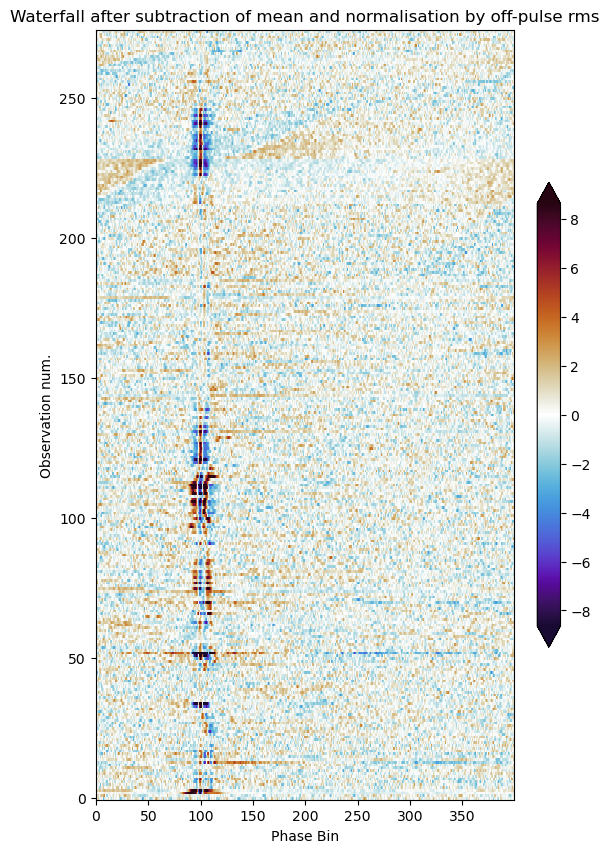

In [7]:
if exist_BE:
    # Mike's alignment function # Been moved to the step_1 alignment function
    #plt.plot(BE_aligned[:,100])   
    #BE_aligned = psrcelery.data.align_and_scale(BE_aligned.T, BE_temp, nharm='auto').T
    #plt.plot(BE_aligned[:,100])   
    #plt.show()

    BE_orig = np.copy(BE_aligned)
    BE_offpulse, _ = _find_off_pulse(BE_temp)
    BE_offrms = np.std(BE_aligned[BE_offpulse,:], axis=0)
    BE_aligned = (BE_aligned.T - BE_temp).T/BE_offrms # mean-subtracted and normalised
    #plt.plot(BE_aligned[:,100])   
    #plt.show()
    with plt.style.context(plot_style):
        plt.clf()
        fig = plt.figure(num=1)
        if use_bk_bgd:
            cmap2 = cmr.iceburn
        else:
            cmap2 = cmr.fusion_r
            
        fig.set_size_inches(6, 10)
        vmax = np.percentile(abs(BE_aligned), 99.875)
        vmin = -vmax
        if vmin > np.min(BE_aligned) and vmax < np.max(BE_aligned):
            extend = 'both'
        elif vmin > np.min(BE_aligned):
            extend = 'min'
        elif vmax < np.max(BE_aligned):
            extend = 'max'
                    
        p = plt.imshow(BE_aligned.T, vmin=vmin, vmax=vmax, cmap=cmap2,
                       origin='lower', aspect='auto', interpolation='nearest')
        fig.colorbar(p, extend=extend, fraction=0.05)
        plt.ylabel('Observation num.')
        plt.xlabel('Phase Bin')
        plt.title('Waterfall after subtraction of mean and normalisation by off-pulse rms')
        plt.show()


Unless your pulse profile is very wide, it is unwise to include the entire rotation in the PCA as it will look for patterns in the off-pulse which are not relevant to the analysis. Find the rough on-pulse region and make a bin-wise mask (array of booleans). If the profile has an interpulse, that region should be included as well, cutting out any off-pulse region between the MP and IP. 

In [8]:
# Try to set the phase cuts automatically
nbin = len(BE_temp)
phase = np.linspace(0, 1, nbin)

# define on-pulse ranges as fractions
ip_exist = len(phase[phase > 0.65]) != len(phase[BE_offpulse][phase[BE_offpulse] > 0.65]) # all points near IP are "off-pulse"
one_bin = 1/nbin
peak_min = np.max(phase[BE_offpulse][phase[BE_offpulse] < 0.25])-2*one_bin
peak_max = np.min(phase[BE_offpulse][phase[BE_offpulse] > 0.25])+2*one_bin
off_min = peak_min - min(peak_min/2, 0.03)
off_max = min(2*peak_max - peak_min, 0.65)
if ip_exist:
    ip_midd = np.mean(phase[np.logical_and(BE_offpulse, phase >= 0.65)])
    ip_min = np.max(phase[BE_offpulse][phase[BE_offpulse] < ip_midd])-2*one_bin
    ip_max = np.min(phase[BE_offpulse][phase[BE_offpulse] > ip_midd])+2*one_bin
    off_pulse = np.logical_and(phase > peak_max, phase < off_max)
    inter_pulse = np.logical_and(phase > ip_min, phase < ip_max)
    if np.abs(np.mean(BE_temp[off_pulse]) - np.mean(BE_temp[inter_pulse])) < np.std(BE_temp[off_pulse]):
        ip_midd = 0.75
        ip_min = 0.71
        ip_max = 0.79
        inter_pulse = np.logical_and(phase > ip_min, phase < ip_max)
        if np.abs(np.mean(BE_temp[off_pulse]) - np.mean(BE_temp[inter_pulse])) < np.std(BE_temp[off_pulse]):
            print("An IP exists but limits cannot be set automatically!!")
            ip_exist = False


<Figure size 640x480 with 0 Axes>

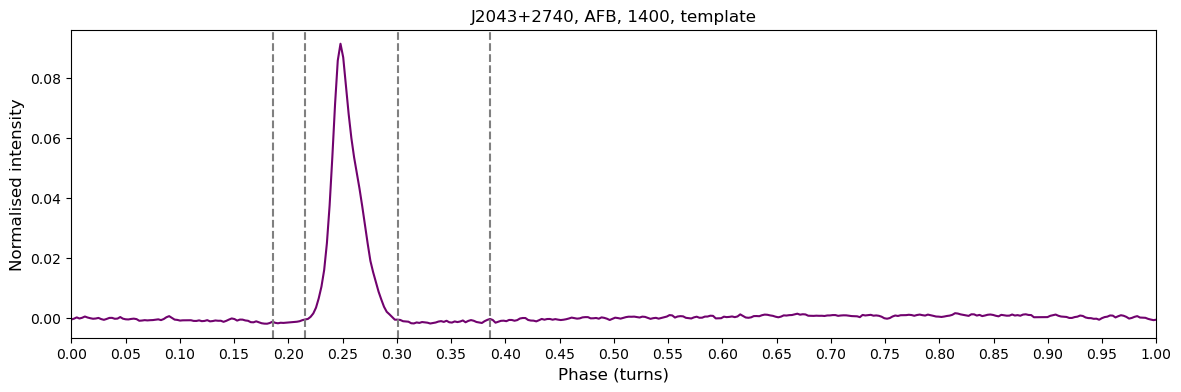

In [9]:
# plot the templates and define some useful values
with plt.style.context(plot_style):
    plt.clf()
    fig = plt.figure(num=2)
    fig.set_size_inches(14, 4)

    plt.title("{}, {}, {}, template".format(psr, BE, freq))
    BE_nbin = len(BE_temp)
    plt.plot(np.linspace(0, 1, BE_nbin), BE_temp, color=c2)

    ylims = plt.ylim()
    plt.vlines([off_min, peak_min, peak_max, off_max], ylims[0], ylims[1], linestyle='dashed', colors='grey')
    if ip_exist:
        plt.vlines([ip_min, ip_max], ylims[0], ylims[1], linestyle='dashed', colors='grey')
        
    plt.ylim(ylims)
    plt.xticks(np.linspace(0, 1, 21))
    plt.xlim(0, 1)
    plt.ylabel('Normalised intensity', fontsize=12)
    plt.xlabel('Phase (turns)', fontsize=12)
    plt.savefig(os.path.join(plots_dir, desc+'_template.png'), bbox_inches='tight')
    plt.show()


Sometimes the function to find the pulse will mis-identify an interpulse, so carefully check the plot above and use the following cell to adjust the limits as necessary. 

In [10]:
# if necessary, use these lines to modify the limits
#off_min = 0.17
#peak_min = 0.21
#peak_max = 0.28
#off_max = 0.35
#ip_exist = False
#ip_min = 0.73
#ip_max = 0.78


We first need to fit the profiles to get eigenvalues and eigenvectors. The eigenvectors describe the profiles, including bin-wise dependence. The eigenvalues describe the variation between profiles. Once we have the eigenvalues, we can fit GPs, and then find correlations. 

In [11]:
if exist_BE:
    BE_bins = np.linspace(0, 1, num=BE_aligned.shape[0], endpoint=False)
    BE_mask = np.logical_and(BE_bins > off_min, BE_bins < off_max)
    BE_off = np.logical_or(BE_bins[BE_mask] < peak_min, BE_bins[BE_mask] > peak_max)
    if ip_exist:
        BE_mask = np.logical_or(BE_mask, np.logical_and(BE_bins > ip_min, BE_bins < ip_max))
        BE_off = np.logical_or(BE_bins[BE_mask] < peak_min, np.logical_and(BE_bins[BE_mask] > peak_max, BE_bins[BE_mask] < off_max))
    
    #BE_range = (int(peak_min*BE_nbin), int(peak_max*BE_nbin))
    #BE_range = (0, BE_aligned.shape[0])
    BE_pca = PCA(n_components=30)
    BE_comps_all = BE_pca.fit_transform(BE_aligned[BE_mask,:].T) * BE_offrms.reshape(-1,1)


In [12]:
print("Check that these are number of profiles by number of components:")
if exist_BE:
    print(BE+":", BE_comps_all.shape)
    
print("Check that these are number of components by number of bins (used):")
if exist_BE:
    print(BE+":", BE_pca.components_.shape)


Check that these are number of profiles by number of components:
AFB: (275, 30)
Check that these are number of components by number of bins (used):
AFB: (30, 80)


In [13]:
if exist_BE:
    BE_rms, _ = get_rms_bline(BE_aligned)
    print(len(BE_rms))
    print("The (min, median, and max) off-pulse rms for {} are ({:.5f}, {:.5f}, {:.5f})".format(BE, BE_rms.min(), np.median(BE_rms), BE_rms.max()))


275
The (min, median, and max) off-pulse rms for AFB are (0.40752, 0.91493, 2.78169)


In [14]:
if exist_BE:
    bad_mjds_BE = bad_mjds_eigs(BE_aligned, BE_mjds_new, peak_min, peak_max)
    

206
The MJD of this observation is 53290.0733804


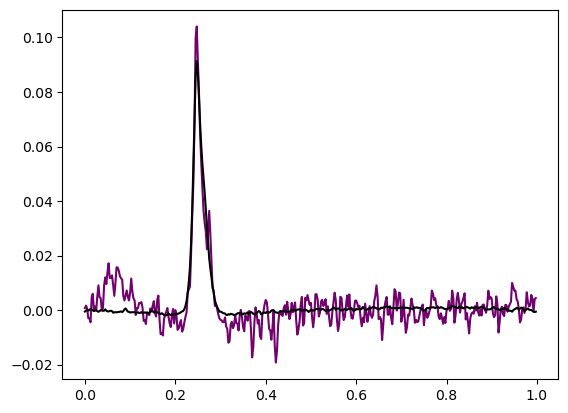

In [36]:
if exist_BE: # plot a random observation marked as "bad" above
    print(len(bad_mjds_BE))
    imjd = np.random.randint(len(bad_mjds_BE))
    bad_mjd = bad_mjds_BE[imjd]
    #lim = BE_mjds_new == bad_mjd
    print("The MJD of this observation is", bad_mjd)
    with plt.style.context(plot_style):
        plt.clf()
        plt.plot(BE_bins, BE_orig[:,imjd], color=c2)
        plt.plot(BE_bins, BE_temp, '-', color=c1)
        plt.show()


In [16]:
# define axes parameters for following plots
#w = 0.92
l1 = 0.1
b = 0.1
h = 0.82
sep = 0.08
frac = 0.5
l2 = l1 + frac + sep
w1 = frac
w2 = 1 - l2 - sep


<Figure size 640x480 with 0 Axes>

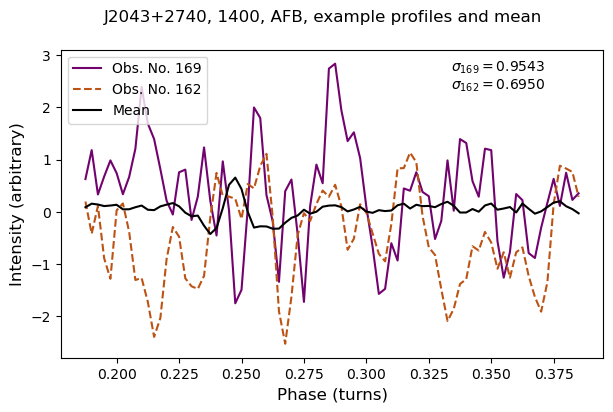

In [38]:
if exist_BE:
    with plt.style.context(plot_style):
        plt.clf()
        fig = plt.figure(num=3)
        fig.set_size_inches(7, 4)
        fig.suptitle("{}, {}, {}, example profiles and mean".format(psr, freq, BE))
        first, second = np.random.randint(BE_comps_all.shape[0], size=2)
        if ip_exist:
            ax1 = fig.add_axes((l1, b, w1, h))
            ax2 = fig.add_axes((l2, b, w2, h))
            mask1 = np.logical_and(BE_mask, BE_bins < 0.65)
            mask2 = np.logical_and(BE_mask, BE_bins >= 0.65)
            mean_mask1 = np.arange(len(BE_pca.mean_)) < len(BE_bins[mask1])
            mean_mask2 = np.arange(len(BE_pca.mean_)) >= len(BE_bins[mask1])
            for ax, mask, mmask in zip([ax1, ax2], [mask1, mask2], [mean_mask1, mean_mask2]):
                ax.plot(BE_bins[mask], BE_aligned[mask,first], color=c2, label='Obs. No. {}'.format(first)) #two example profiles of the two states
                ax.plot(BE_bins[mask], BE_aligned[mask,second], color=c3, ls='--', label='Obs. No. {}'.format(second))
                ax.plot(BE_bins[mask], BE_pca.mean_[mmask], color=c1, label='Mean') #mean plotted, subtracted off before computing
                ax.set_xlabel('Phase (turns)', fontsize=12)
        
            #ax1.set_xlim()
            ax = ax1

        else:
            ax = plt.gca()
            plt.plot(BE_bins[BE_mask], BE_aligned[BE_mask,first], color=c2, label='Obs. No. {}'.format(first)) #two example profiles of the two states
            plt.plot(BE_bins[BE_mask], BE_aligned[BE_mask,second], color=c3, ls='--', label='Obs. No. {}'.format(second))
            plt.plot(BE_bins[BE_mask], BE_pca.mean_, color=c1, label='Mean') #mean plotted, subtracted off before computing
            plt.xlabel('Phase (turns)', fontsize=12)
    
        #plt.xlim(peak_min*BE_nbin, peak_max*BE_nbin)
        #plt.xlim(BE_range[0], BE_range[1])
        plt.text(0.72, 0.87, '$\sigma_{{{:d}}} = {:.4f}$\n$\sigma_{{{:d}}} = {:.4f}$'.format(first, BE_rms[first], second, BE_rms[second]), transform=ax.transAxes)
        #plt.text(0.025, 0.87, '$N_{{obs,purple}} = {}$\n$N_{{obs,red}} = {}$'.format(first, second), transform=ax.transAxes)
        ax.set_ylabel('Intensity (arbitrary)', fontsize=12)
        plt.legend(loc=2)
        plt.savefig(os.path.join(plots_dir, desc+'_ex_profs.png'), bbox_inches='tight')
        plt.show()


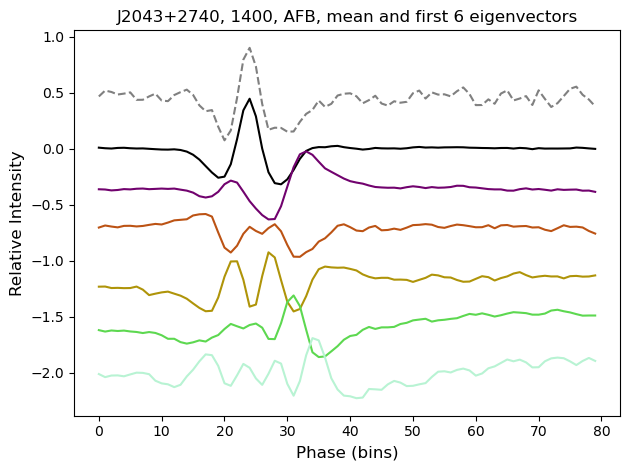

In [18]:
# plot the first five principal components
if exist_BE:
    with plt.style.context(plot_style):
        plt.clf()
        plt.title("{}, {}, {}, mean and first 6 eigenvectors".format(psr, freq, BE))
        plt.plot(0.5*(BE_pca.mean_/BE_pca.mean_.max())+0.4, color='grey', ls='--')
        plt.plot(BE_pca.components_[0,:], color=c1)
        plt.plot(BE_pca.components_[1,:]-0.4, color=c2)
        plt.plot(BE_pca.components_[2,:]-0.8, color=c3)
        plt.plot(BE_pca.components_[3,:]-1.2, color=c4)
        plt.plot(BE_pca.components_[4,:]-1.6, color=c5)
        plt.plot(BE_pca.components_[5,:]-2, color=c6)
        if ip_exist:
            mask1 = np.logical_and(BE_mask, BE_bins < 0.65)
            ip_line = len(BE_bins[mask1])
            ylims = plt.ylim()
            plt.vlines(ip_line, ylims[0], ylims[1], color='grey', ls=':')
            plt.ylim(ylims)
        
        plt.ylabel("Relative Intensity", fontsize=12)
        plt.xlabel("Phase (bins)", fontsize=12)

        #if BE_range[0] == 0 and BE_range[1] == BE_nbin:
        #plt.xlim(peak_min*BE_nbin, peak_max*BE_nbin)

        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, desc+'_components.png'), bbox_inches='tight')
        plt.show()


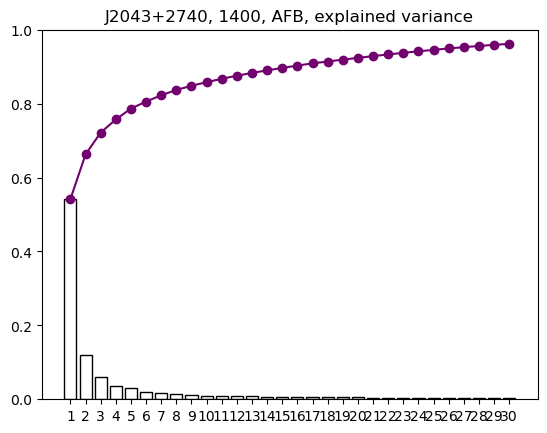

In [19]:
# explained ratio, the variance of each component, and can compute a cumulative sum
if exist_BE:
    with plt.style.context(plot_style):
        plt.clf()
        plt.title("{}, {}, {}, explained variance".format(psr, freq, BE))
        plt.bar(np.arange(1, BE_comps_all.shape[1]+1), BE_pca.explained_variance_ratio_, color='None', edgecolor='k', tick_label=np.arange(1, BE_comps_all.shape[1]+1))
        plt.plot(np.arange(1, BE_comps_all.shape[1]+1), np.cumsum(BE_pca.explained_variance_ratio_[:BE_comps_all.shape[1]+1]), marker='o', color=c2)
        plt.ylim(0, 1)
        plt.savefig(os.path.join(plots_dir, desc+'_variance.png'), bbox_inches='tight')
        plt.show()


In [20]:
if exist_BE:
    #print(BE+":")
    BE_errs_new = err_eigval(BE_aligned[BE_mask,:], BE_pca.components_, BE_off) * BE_offrms.reshape(-1,1)


<Figure size 640x480 with 0 Axes>

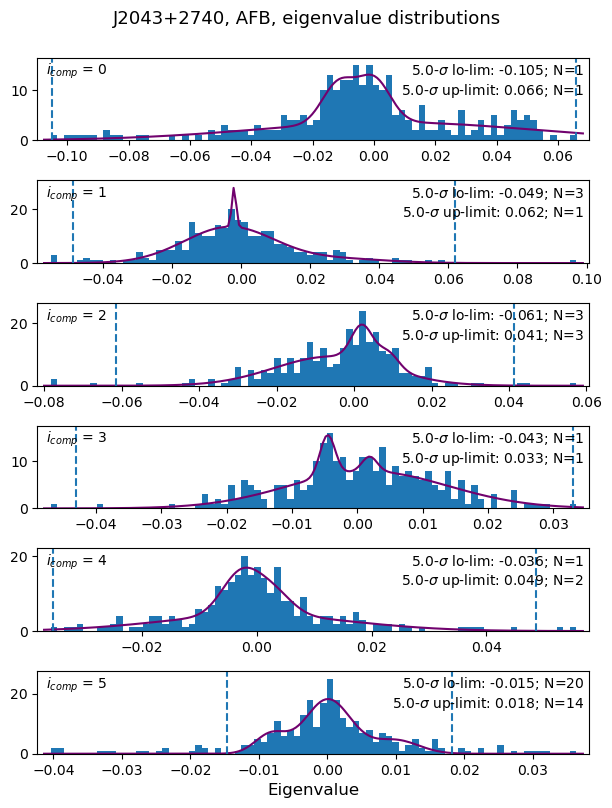

[53867.560742  54084.9556611]


In [21]:
if exist_BE:
    plt.clf()
    BE_mjds_out1 = find_dists_outliers(BE_comps_all, BE_mjds_new, psr, BE, 6, savename=os.path.join(plots_dir, psr+"_BE_{}_eigval_dists.png".format(freq)),
                                        first_out=True, sigma=5)
    BE_mjds_out2 = rolling_out_rej(BE_comps_all, BE_mjds_new, psr, BE, 6, first_out=True, show=False)
    print(BE_mjds_out1)
    #print(BE_mjds_out2)


<Figure size 640x480 with 0 Axes>

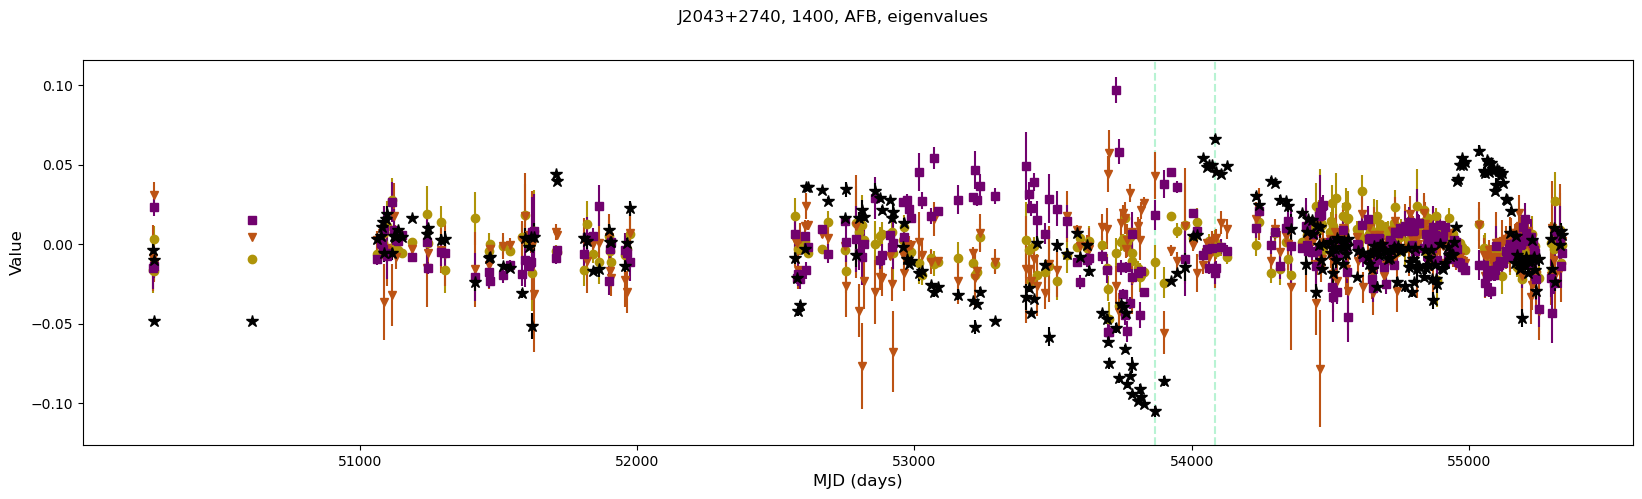

In [22]:
if exist_BE:
    with plt.style.context(plot_style):
        plt.clf()
        fig = plt.figure(figsize=(20, 5))
        fig.suptitle("{}, {}, {}, eigenvalues".format(psr, freq, BE))
        ax1 = fig.gca()
        ax1.errorbar(BE_mjds_new, BE_comps_all[:,3], yerr=BE_errs_new[:,3], fmt='o', ecolor=c4, mec=c4, mfc=c4)
        ax1.errorbar(BE_mjds_new, BE_comps_all[:,2], yerr=BE_errs_new[:,2], fmt='v', ecolor=c3, mec=c3, mfc=c3)
        ax1.errorbar(BE_mjds_new, BE_comps_all[:,1], yerr=BE_errs_new[:,1], fmt='s', ecolor=c2, mec=c2, mfc=c2)
        ax1.errorbar(BE_mjds_new, BE_comps_all[:,0], yerr=BE_errs_new[:,0], fmt='*', ecolor=c1, mec=c1, mfc=c1, ms=9)
        ax1.set_xlabel('MJD (days)', fontsize=12)
        ax1.set_ylabel('Value', fontsize=12)
        vlim = ax1.get_ylim()
        ax1.vlines(BE_mjds_out1, vlim[0], vlim[1], ls='--', color=c6, zorder=1)
        ax1.set_ylim(vlim)
        plt.savefig(os.path.join(plots_dir, desc+"_eigs_v_mjd.png"), bbox_inches='tight')
        plt.show()


53697.9771543


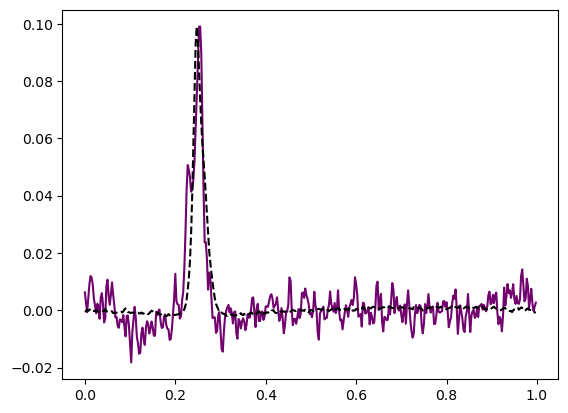

In [41]:
if exist_BE:
    #print(len(BE_mjds_out1))
    #bad_mjd = BE_mjds_out1[12]
    lim = BE_mjds_new > 38000
    imjd = np.argmin(BE_comps_all[:,1][lim])
    bad_mjd = BE_mjds_new[lim][imjd]
    print(bad_mjd)
    with plt.style.context(plot_style):
        plt.clf()
        plt.plot(BE_bins, BE_orig[:,imjd], color=c2)
        plt.plot(BE_bins, BE_temp*BE_orig[:,imjd].max()/BE_temp.max(), '--', color=c1)
        plt.show()


<Figure size 640x480 with 0 Axes>

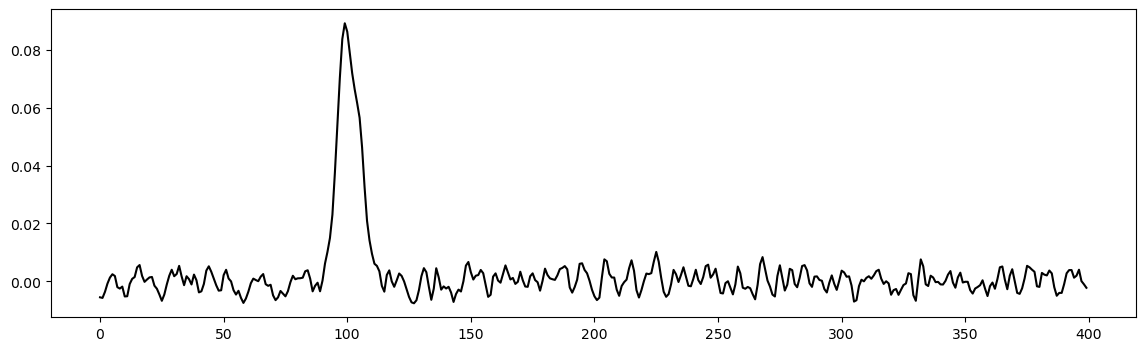

51514.9618408


In [42]:
if exist_BE:
    ncheck = np.random.randint(len(BE_mjds_new))
    #ncheck = 69
    
    with plt.style.context(plot_style):
        plt.clf()
        fig = plt.figure(num=5)
        fig.set_size_inches(14,4)
        plt.plot(BE_orig[:,ncheck], '-', color=c1)
        plt.show()
        
    print(BE_mjds_new[ncheck])


In [25]:
do_binning = False # change this if desired
# add binning lengths for pulsars into this dictionary; initial guesses from Lyne+2010
bin_lens_dict = {'B1828-11': 100,
                 'B0105+65': 100,
                 'B0329+54': 50,
                 'J0538+2817': 100,
                 'B0740-28': 50,
                 'B0059+65': 100,
                 'B0919+06': 150,
                 'B0950+08': 500,
                 'B1540-06': 400,
                 'B1642-03': 200,
                 'B1714-34': 400,
                 'B1818-04': 400,
                 'B1822-09': 100,
                 'B1826-17': 300,
                 'B1839+09': 300,
                 'B1903+07': 400,
                 'B1907+00': 400,
                 'B1929+20': 400,
                 'B1931+24': 100,
                 'B2035+36': 300,
                 'J2043+2740': 200,
                 'B2148+63': 600}

In [26]:
bin_length = bin_lens_dict[psr] if psr in bin_lens_dict.keys() else 100
bin_overlap = 0.2
if exist_BE and do_binning:
    print(BE+":", BE_comps_all.shape, len(BE_mjds_new))
    try:
        binned_BE, bin_errs_BE, BE_mjds_short = bin_array(BE_comps_all, BE_mjds_new, BE_rms, bin_length, bin_overlap)
    except ValueError:
        print("Trying a longer bin length")
        bin_length *= 2
        binned_BE, bin_errs_BE, BE_mjds_short = bin_array(BE_comps_all, BE_mjds_new, BE_rms, bin_length, bin_overlap)
        
    print(BE+":", binned_BE.shape)
    

In [27]:
if exist_BE and do_binning:
    with plt.style.context(plot_style):
        plt.clf()
        plt.figure(figsize=(20, 4))
        plt.title("{}, {}, {}, binned ({}d, {}% overlap) eigenvalues".format(psr, freq, BE, bin_length, int(bin_overlap*100)))
        plt.plot(BE_mjds_short, binned_BE[:,3]/max(abs(binned_BE[:,3])), 'o', color=c4)
        plt.plot(BE_mjds_short, binned_BE[:,2]/max(abs(binned_BE[:,2])), 'v', color=c3)
        plt.plot(BE_mjds_short, binned_BE[:,1]/max(abs(binned_BE[:,1])), 's', color=c2)
        plt.plot(BE_mjds_short, binned_BE[:,0]/max(abs(binned_BE[:,0])), '*', color=c1, ms=10)
        plt.show()


In [28]:
# Save the eigenvectors and eigenvalues
var_dict = {}#'val_bin_len': bin_length, 'val_bin_lap': bin_overlap}
if exist_BE:
    var_dict[BE+'_errs'] = BE_errs_new
    var_dict[BE+'_mean'] = BE_pca.mean_
    var_dict[BE+'_values'] = BE_comps_all
    var_dict[BE+'_vectors'] = BE_pca.components_
    var_dict[BE+'_mjds'] = BE_mjds_new
    #var_dict[BE+'_bin_vals'] = binned_BE
    #var_dict[BE+'_bin_mjds'] = BE_mjds_short
    var_dict[BE+'_rms'] = BE_rms


In [29]:
out_file = os.path.join(data_dir, '{}_{}_eigs.npz'.format(psr, freq))
if exist_BE:
    old_dict = {}
    if os.path.exists(out_file):
        with np.load(out_file, allow_pickle=True) as f:
            for key in f.keys():
                if key not in var_dict.keys():
                    old_dict[key] = f[key]
                else:
                    print("Replacing an older value for "+key)
                
    np.savez(out_file, **var_dict, **old_dict)


Replacing an older value for AFB_errs
Replacing an older value for AFB_mean
Replacing an older value for AFB_values
Replacing an older value for AFB_vectors
Replacing an older value for AFB_mjds
Replacing an older value for AFB_rms
